In [1]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
import glob
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
############# Path Configuration #############
DATA_STRUCTURE_PATH = "/kaggle/input/berlin-bin-data/download_checkpoint.json"
IMAGE_BASE_DIR = "/kaggle/input/geovaluatorberlin/images"
MODELS_DIR = "best_regression_model_berlin.pth"

NUM_EPOCHS_1 = 4
NUM_EPOCHS_2 = 3

In [3]:
def set_seed():
    seed = 28
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
set_seed()

In [4]:
############# Functions and Classes #############

class StreetViewDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

def evaluate_regression_model(model, test_loader, criterion):
    model.eval()
    model = model.to(device)
    total_loss = 0.0
    total_mae = 0.0
    predictions = []
    true_values = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.float().to(device)
            labels = labels.unsqueeze(1)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            
            # Calculate MAE for this batch
            batch_mae = torch.nn.functional.l1_loss(outputs, labels, reduction='sum')
            total_mae += batch_mae.item()
        
            predictions.extend(outputs.cpu().numpy())
            true_values.extend(labels.cpu().numpy())
    
    # MSE and RMSE
    mse = total_loss / len(test_loader.dataset)
    rmse = np.sqrt(mse)
    
    # MAE
    mae = total_mae / len(test_loader.dataset)
    
    predictions = np.array(predictions).flatten()
    true_values = np.array(true_values).flatten()
    
    # R2 score
    r2 = r2_score(true_values, predictions)
    
    print(f'Test MSE: {mse:.4f}')
    print(f'Test RMSE: {rmse:.4f}')
    print(f'Test MAE: {mae:.4f}')
    print(f'Test R2: {r2:.4f}')
    
    return mse, rmse, mae, r2

# Regression Model
class EfficientNetRegressor(nn.Module):
    def __init__(self, model_name='efficientnet_b3'):
        super(EfficientNetRegressor, self).__init__()
        
        self.backbone = timm.create_model(model_name, 
                                         pretrained=True,
                                         num_classes=0,
                                         global_pool='avg')
        
        # Single output neuron for regression
        self.regressor = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.backbone.num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
            
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            
            nn.Dropout(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        features = self.backbone(x)
        return self.regressor(features)

def train_model_regression(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=None):
    model = model.to(device)
    train_mses = []
    train_maes = []
    val_mses = []
    val_maes = []
    best_val_mse = float('inf')

    BATCH_MAX = 20
    BATCH_COUNT = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_mse = 0.0
        running_mae = 0.0
    
        for images, labels in tqdm(train_loader):

            images = images.to(device)
            labels = labels.float().to(device)
            labels = labels.unsqueeze(1)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)  # MSE loss
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Calculate MSE
            batch_mse = loss.item()
            running_mse += batch_mse * images.size(0)
            
            # Calculate MAE
            batch_mae = torch.mean(torch.abs(outputs - labels)).item()
            running_mae += batch_mae * images.size(0)
        
        # Calculate epoch training metrics
        epoch_train_mse = running_mse / len(train_loader.dataset)
        epoch_train_mae = running_mae / len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_mse = 0.0
        val_mae = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                
                images = images.to(device)
                labels = labels.float().to(device)
                labels = labels.unsqueeze(1)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_mse += loss.item() * images.size(0)
                
                # Calculate validation MAE
                batch_val_mae = torch.mean(torch.abs(outputs - labels)).item()
                val_mae += batch_val_mae * images.size(0)
        
        # Calculate epoch validation metrics
        epoch_val_mse = val_mse / len(val_loader.dataset)
        epoch_val_mae = val_mae / len(val_loader.dataset)
        
        # Store metrics
        train_mses.append(epoch_train_mse)
        train_maes.append(epoch_train_mae)
        val_mses.append(epoch_val_mse)
        val_maes.append(epoch_val_mae)
        
        # Step scheduler
        if scheduler:
            scheduler.step()
        
        # Print summary with both MSE and MAE
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train MSE: {epoch_train_mse:.4f}, Train MAE: {epoch_train_mae:.4f}')
        print(f'Val MSE: {epoch_val_mse:.4f}, Val MAE: {epoch_val_mae:.4f}')
        
        # Save best model based on validation MSE
        if epoch_val_mse < best_val_mse:
            best_val_mse = epoch_val_mse
            torch.save(model.state_dict(), MODELS_DIR)
            print(f'New best model with Val MSE: {epoch_val_mse:.4f}')
        
    return train_mses, train_maes, val_mses, val_maes
    
def plot_regression_loss(train_mses, val_mses, name):
    SAVE_NAME = f"{name}_regression_metrics_berlin.pdf"
    plt.figure(figsize=(6, 4))
    
    # Plot MSE
    plt.plot(train_mses,'o-',label='Train MSE')
    plt.plot(val_mses,'o-',label='Val MSE')
    plt.title('Training and Validation MSE', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('MSE', fontsize=12)
    plt.legend(fontsize=12)
    
    plt.tick_params(axis='x', which='major', labelsize=12)
    plt.tick_params(axis='y', which='major', labelsize=12)
    
    plt.tight_layout()
    plt.savefig(SAVE_NAME, dpi=300)
    plt.show()

def plot_regression_mae(train_maes, val_maes, name):
    SAVE_NAME = f"{name}_regression_metrics_berlin.pdf"
    plt.figure(figsize=(6, 4))
    
    # Plot MSE
    plt.plot(train_maes,'o-',label='Train MAE')
    plt.plot(val_maes,'o-',label='Val MAE')
    plt.title('Training and Validation MAE', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('MAE in Euro', fontsize=12)
    plt.legend(fontsize=12)

    plt.tick_params(axis='x', which='major', labelsize=12)
    plt.tick_params(axis='y', which='major', labelsize=12)
    
    plt.tight_layout()
    plt.savefig(SAVE_NAME, dpi=300)
    plt.show()

def transform_mae_to_euros(normalized_mae, scaler):
    # Extract original log scale bounds
    min_log = scaler.data_min_[0]
    max_log = scaler.data_max_[0]

    # Convert normalized MAE back to log-space difference (linear part)
    mae_log = normalized_mae * (max_log - min_log)

    # Use midpoint of the log range as representative rent
    mid_log = (min_log + max_log) / 2
    
    # Local linearization of expm1: delta_rent = exp(mid_log) * delta_log
    euro_mae = np.exp(mid_log) * mae_log

    return euro_mae

In [5]:
############# Data handling #############
with open(DATA_STRUCTURE_PATH, 'r') as f:
    data = json.load(f)
    
# Create a district to normalized price mapping
district_price_mapping = {}

for item in data['successful_downloads']:
    district = item['district']
    normalized_price = item['normalized_price']
    district_price_mapping[district] = normalized_price

image_paths = []
image_labels = []
district_names_list = []

# Get all district folders
all_district_folders = [d for d in os.listdir(IMAGE_BASE_DIR) 
                       if os.path.isdir(os.path.join(IMAGE_BASE_DIR, d))]

# Load images and assign the normalized price labels
for district_folder in all_district_folders:
    if district_folder in district_price_mapping:
        average_price_id = district_price_mapping[district_folder]
        district_image_dir = os.path.join(IMAGE_BASE_DIR, district_folder)
        
        # Get all images in this district folder
        pattern = os.path.join(district_image_dir, '*.jpg')
        image_files = glob.glob(pattern)
        
        for image_path in image_files:
            image_paths.append(image_path)
            image_labels.append(average_price_id)
            district_names_list.append(district_folder)

# Create DataFrame
image_df = pd.DataFrame({
    'image_path': image_paths,
    'label': image_labels,
    'district': district_names_list
})

# Group images by label
label_groups = {}
for label in image_df['label'].unique():
    label_groups[label] = image_df[image_df['label'] == label]

# Split each label separately
train_dfs, val_dfs, test_dfs = [], [], []

for label, group in label_groups.items():
    train_val, test = train_test_split(group, test_size=0.0654, random_state=42)
    train, val = train_test_split(train_val, test_size=0.07, random_state=42)
    
    train_dfs.append(train)
    val_dfs.append(val)
    test_dfs.append(test)

train_df = pd.concat(train_dfs).reset_index(drop=True)
val_df = pd.concat(val_dfs).reset_index(drop=True)
test_df = pd.concat(test_dfs).reset_index(drop=True)


# Define transforms for Imagenet B3 (300x300)
INPUT_SIZE = 300

train_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalization for ImageNet
])

val_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = StreetViewDataset(train_df, transform=train_transform)
val_dataset = StreetViewDataset(val_df, transform=val_transform)
test_dataset = StreetViewDataset(test_df, transform=val_transform)

# Create dataloaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 545
Val batches: 43
Test batches: 43


In [6]:
############# Training #############
# GPU Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Put model on GPU
model = EfficientNetRegressor(model_name='efficientnet_b3')
model = model.to(device)

print(f"GPU available: {torch.cuda.is_available()}")

# MSELoss for regression
criterion = nn.MSELoss()

# Feature Extraction
print("1) Feature Extraction")
for param in model.backbone.parameters():
    param.requires_grad = False

#optimizer_stage1 = optim.Adam(model.regressor.parameters(), lr=1e-3)
optimizer_stage1 = torch.optim.AdamW(model.regressor.parameters(),lr=3e-4,weight_decay=1e-4)

# Train with metrics
train_mses_s1, train_maes_s1, val_mses_s1, val_maes_s1 = train_model_regression(
    model, train_loader, val_loader, criterion, optimizer_stage1, 
    num_epochs=NUM_EPOCHS_1
)

# Fine-Tuning
print("2) Fine-Tuning")
model.load_state_dict(torch.load('/kaggle/working/best_regression_model_berlin.pth'))

for param in model.backbone.parameters():
    param.requires_grad = True

optimizer_stage2 = torch.optim.AdamW(
    [
        {"params": model.regressor.parameters(), "lr": 1e-4},
        {"params": model.backbone.parameters(), "lr": 3e-5},
    ],
    weight_decay=5e-4
)

scheduler = StepLR(optimizer_stage2, step_size=5, gamma=0.1)

train_mses_s2, train_maes_s2, val_mses_s2, val_maes_s2 = train_model_regression(
    model, train_loader, val_loader, criterion, optimizer_stage2, 
    num_epochs=NUM_EPOCHS_2, scheduler=scheduler
)

Using device: cuda


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

GPU available: True
1) Feature Extraction


100%|██████████| 545/545 [02:12<00:00,  4.13it/s]



Epoch 1/4:
Train MSE: 0.0411, Train MAE: 0.1581
Val MSE: 0.0358, Val MAE: 0.1477
New best model with Val MSE: 0.0358


100%|██████████| 545/545 [01:32<00:00,  5.90it/s]



Epoch 2/4:
Train MSE: 0.0370, Train MAE: 0.1502
Val MSE: 0.0353, Val MAE: 0.1463
New best model with Val MSE: 0.0353


100%|██████████| 545/545 [01:31<00:00,  5.94it/s]



Epoch 3/4:
Train MSE: 0.0358, Train MAE: 0.1476
Val MSE: 0.0350, Val MAE: 0.1456
New best model with Val MSE: 0.0350


100%|██████████| 545/545 [01:32<00:00,  5.88it/s]



Epoch 4/4:
Train MSE: 0.0345, Train MAE: 0.1448
Val MSE: 0.0344, Val MAE: 0.1442
New best model with Val MSE: 0.0344
2) Fine-Tuning


100%|██████████| 545/545 [03:39<00:00,  2.48it/s]



Epoch 1/3:
Train MSE: 0.0329, Train MAE: 0.1415
Val MSE: 0.0326, Val MAE: 0.1396
New best model with Val MSE: 0.0326


100%|██████████| 545/545 [03:39<00:00,  2.49it/s]



Epoch 2/3:
Train MSE: 0.0274, Train MAE: 0.1293
Val MSE: 0.0317, Val MAE: 0.1372
New best model with Val MSE: 0.0317


100%|██████████| 545/545 [03:39<00:00,  2.49it/s]



Epoch 3/3:
Train MSE: 0.0220, Train MAE: 0.1166
Val MSE: 0.0323, Val MAE: 0.1384


2.367436065313662
3.2072080200005186
1) Metrics


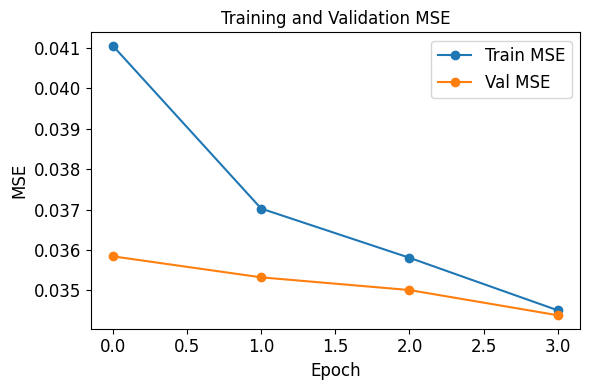

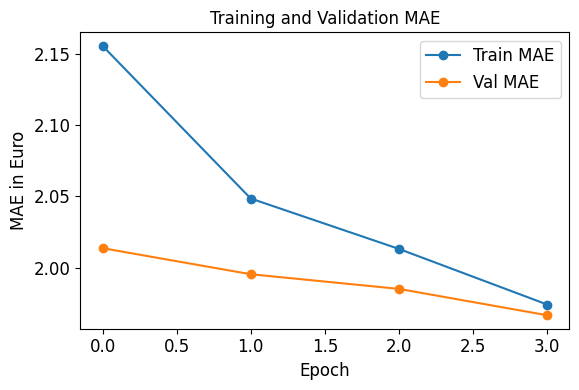

2) Metrics


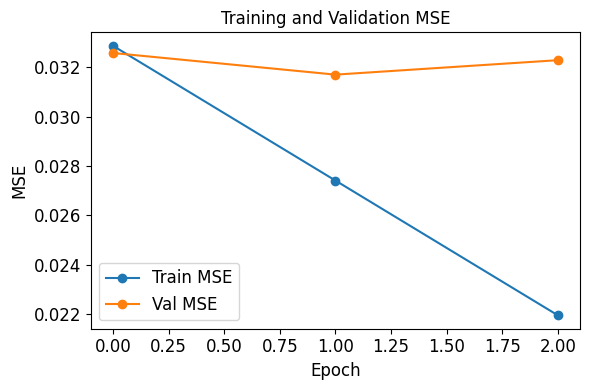

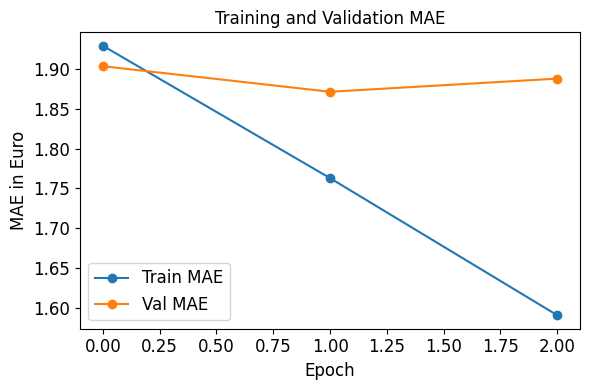

Full Metrics


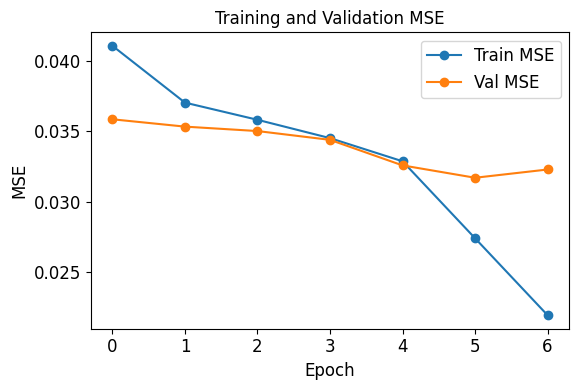

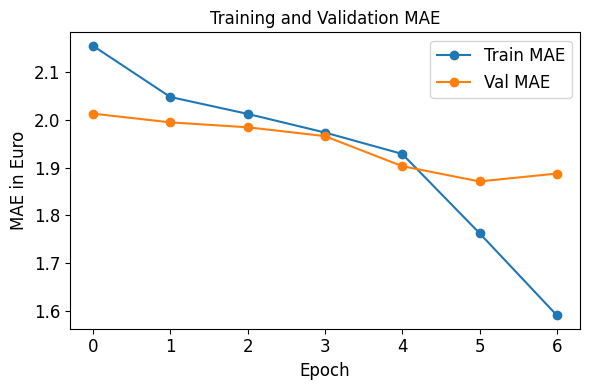

Test MSE: 0.0332
Test RMSE: 0.1821
Test MAE: 0.1410
Test R2: 0.1870


In [7]:
########## Evaluation ##########

# Calculate MAE to Euro

with open(DATA_STRUCTURE_PATH, 'r') as f:
    data = json.load(f)

rent_prices = {}
districts = []

for item in data['successful_downloads']:
    district = item['district']
    districts.append(district)
    rent_price = item['rent_price']
    rent_prices[district] = rent_price

rent_prices
districts = list(set(districts))

rent = []
for district in districts:
    rent.append(rent_prices[district])

log_rent = np.log1p(rent)
log_rent_2d = log_rent.reshape(-1, 1)
scaler = scaler = MinMaxScaler()
normalized_rent = scaler.fit_transform(log_rent_2d)

min_log = scaler.data_min_[0]
max_log = scaler.data_max_[0]

print(min_log)
print(max_log)


print("1) Metrics")
plot_regression_loss(train_mses_s1, val_mses_s1, "metrics_1_loss")

euro_train_maes_1 = []
euro_val_maes_1 = []
for train_mae in train_maes_s1:
    euro_train_maes_1.append(transform_mae_to_euros(train_mae, scaler))

for val_mae in val_maes_s1:
    euro_val_maes_1.append(transform_mae_to_euros(val_mae, scaler))

plot_regression_mae(euro_train_maes_1, euro_val_maes_1, "metrics_1_mae")

                           
print("2) Metrics")
plot_regression_loss(train_mses_s2, val_mses_s2, "metrics_2_loss")

euro_train_maes_2 = []
euro_val_maes_2 = []
for train_mae in train_maes_s2:
    euro_train_maes_2.append(transform_mae_to_euros(train_mae, scaler))

for val_mae in val_maes_s2:
    euro_val_maes_2.append(transform_mae_to_euros(val_mae, scaler))

plot_regression_mae(euro_train_maes_2, euro_val_maes_2, "metrics_2_mae")


print("Full Metrics")
full_train_mses = train_mses_s1 + train_mses_s2
full_val_mses = val_mses_s1 + val_mses_s2

full_train_maes = euro_train_maes_1 + euro_train_maes_2
full_val_maes = euro_val_maes_1 + euro_val_maes_2

plot_regression_loss(full_train_mses, full_val_mses, "metrics_full_loss")
plot_regression_mae(full_train_maes, full_val_maes, "metrics_full_mae")

model.load_state_dict(torch.load(MODELS_DIR))
mse, rmse, mae, r2 = evaluate_regression_model(model, test_loader, criterion)